<a href="https://colab.research.google.com/github/hari1991/Edureka-PGDAIML/blob/main/HandwrittenCharacterRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mid Program Project II

## Initial setup


In [ ]:
!mkdir -p images-data
!rm -rf images-data/*
!rm -rf words/
!rm -rf sample_data/
!rm -rf __MACOSX/
!rm -rf combined.zip
!rm -rf parser.txt
!rm -rf text-data.zip

!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partaa -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partab -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partac -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partad -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partae -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partaf -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partag -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partah -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partai -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partaj -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partak -P images-data/
!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/images.zip.partal -P images-data/

!cat images-data/images.zip.parta*>combined.zip
!apt install p7zip-full
!unzip combined.zip

!wget https://github.com/hari1991/Edureka-PGDAIML/raw/main/text-data.zip
!unzip text-data.zip
!sed -i 's/\r\n//g' parser.txt



## 1.Read the parser.txt file containing the image id and the respective word for that image and take the first 10000 instances for training and testing of the model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import string

import cv2
import os

import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,Conv2D,Flatten,MaxPool2D,Activation,Conv1D, MaxPooling1D, Bidirectional, LSTM,MaxPooling2D,Reshape,Lambda
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
df = pd.read_csv("parser.txt", sep="\s", on_bad_lines='skip', header=None)


In [ ]:
train_test_dataset = df.head(10000)
type(train_test_dataset)


In [ ]:
df.info()

In [ ]:
df.shape

In [ ]:
img = mpimg.imread('words/a01/a01-000u/a01-000u-00-01.png')
imgplot = plt.imshow(img)
plt.show()

In [ ]:
img.shape

In [ ]:
img.size

In [ ]:
!mkdir -p resized
!rm -rf resized/*

In [ ]:
train_test_dataset.dtypes

### Adding originalFile Path in the test data set

In [ ]:

train_test_dataset[9]=train_test_dataset[0].apply(lambda x: "words/" \
                    +x.split("-")[0] +"/"\
                    +x.split("-")[0]+"-"+x.split("-")[1]+"/"\
                    +x+".png")

### Adding resized image path

In [ ]:
train_test_dataset[10]=train_test_dataset[0].apply(lambda x: "resized/" \
                    +x.split("-")[0] +"/"\
                    +x.split("-")[0]+"-"+x.split("-")[1]+"/"\
                    +x+".png")

### Adding normalized image path

In [ ]:
train_test_dataset[11]=train_test_dataset[0].apply(lambda x: "normalized/" \
                    +x.split("-")[0] +"/"\
                    +x.split("-")[0]+"-"+x.split("-")[1]+"/"\
                    +x+".png")

In [ ]:
train_test_dataset.head(5)

## 2. Images can be of different shape thus resize all your images to have the same shape (for example = (128,32))

In [254]:
def distortion_free_resize(input_file_path, output_file_path, img_size=(128, 32)):
  try:
    w, h = img_size
    image = tf.io.read_file(input_file_path)
    image = tf.image.decode_png(image, 1)
    image = tf.image.resize(image, size=(32,128), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    os.makedirs(os.path.dirname(output_file_path), exist_ok=True)
    tf.io.write_file(output_file_path, tf.image.encode_png(image))
  except Exception as err:
    print(f"Unexpected {err=}, {type(err)=} when processing {input_file_path}")

print("Iterating over the first 10000 records")
for index, row in train_test_dataset.iterrows():
    distortion_free_resize(row[9],row[10])


Iterating over the first 10000 records
Unexpected err=InvalidArgumentError(), type(err)=<class 'tensorflow.python.framework.errors_impl.InvalidArgumentError'> when processing words/a01/a01-117/a01-117-05-02.png


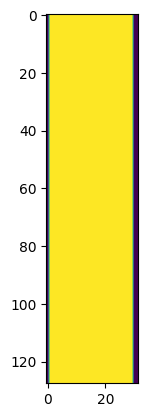

In [255]:
img = mpimg.imread('resized/a01/a01-000u/a01-000u-00-01.png')
imgplot = plt.imshow(img)
plt.show()

## 3. Currently, the pixel values are between 0 to 255, normalize the images so that the pixel values are in range 0 to 1

In [ ]:
!mkdir -p normalized
!rm -rf normalized/*

In [256]:
def normalize_image(input_file_path, output_file_path, target_size=(128, 32)):
    try:
      # Create directories if not exist
      os.makedirs(os.path.dirname(output_file_path), exist_ok=True)

      # Read the image
      image = cv2.imread(input_file_path)

      # Normalize pixel values to range [0, 1]
      normalized_image = image.astype(float) / 255.0

      # Write the Normalize image to the output folder
      cv2.imwrite(output_file_path, (normalized_image).astype(float))
    except Exception as err:
      print(f"Unexpected {err=}, {type(err)=} when processing {input_file_path}")


print("Iterating over the first 10000 records")
for index, row in train_test_dataset.iterrows():
    normalize_image(row[10],row[11])



Iterating over the first 10000 records
Unexpected err=AttributeError("'NoneType' object has no attribute 'astype'"), type(err)=<class 'AttributeError'> when processing resized/a01/a01-117/a01-117-05-02.png


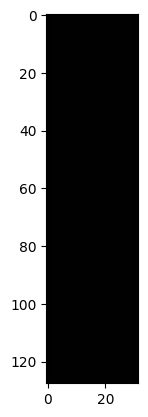

In [257]:
img = mpimg.imread('normalized/a01/a01-000u/a01-000u-00-01.png')
imgplot = plt.imshow(img)
plt.show()

## 4. Create a list of all characters and use the character’s index to encode the actual words into digits

In [258]:
characters=[chr(i) for i in range(32, 127)]
print(characters,len(characters))

def encode_with_index(x):
  try:
    return [characters.index(char) for char in x]
  except Exception as e:
    print(f"Unexpected error while encoding {x}")
    return []

train_test_dataset[12]=train_test_dataset[8].apply(encode_with_index)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~'] 95


<ipython-input-258-a7aa171d0e5c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_dataset[12]=train_test_dataset[8].apply(encode_with_index)


In [259]:
train_test_dataset[[8,12]].head(3)

,8,12
0,A,[33]
1,MOVE,"[45, 47, 54, 37]"
2,to,"[84, 79]"


## 5. Pad all the words to have a similar length

In [260]:
max_length_with_padding = train_test_dataset[8].str.len().max()
print("Max length for padding",max_length_with_padding)

train_test_dataset[13]=pad_sequences(train_test_dataset[12], maxlen=max_length_with_padding, padding='post').tolist()

Max length for padding 18


<ipython-input-260-9d0ecdea048f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_dataset[13]=pad_sequences(train_test_dataset[12], maxlen=max_length_with_padding, padding='post').tolist()


In [ ]:
train_test_dataset[[8,12,13]].head(5)

## 6. Split your dataset for training and testing

In [261]:
#from sklearn.model_selection import train_test_split

# Assuming df contains your DataFrame with 'Padded_Text' and other columns
# X contains features and y contains labels (if available)
train_test_dataset[14]=train_test_dataset[11].apply(lambda x: cv2.imread(x))
X = train_test_dataset[14].to_list()
y = train_test_dataset[8].to_list()  # Replace 'label_column' with the actual label column name

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the split datasets
print("Training set :", len(X_train), len(y_train))
print("Testing set:", len(X_test), len(y_test))




Training set : 8000 8000
Testing set: 2000 2000


<ipython-input-261-5a6e0c51c4c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_test_dataset[14]=train_test_dataset[11].apply(lambda x: cv2.imread(x))


## 7. Create a model for training:


1.   Add several CNN layers to extract the sequence of features
2.   Add Bi-LSTM layers to propagate through the sequence
3.   Add a dense layer (output layer) with total number of neurons as (total number of characters + 1) and the activation as softmax.

In [263]:
# Assuming max_length is the maximum length of your padded sequences
max_length = len(X_train[0])

# Number of unique characters + 1 for padding
num_classes = len(characters) + 1




# Defining CNN layers
def define_cnn_layers(inputs):
    # Convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    #Reshaping necessary
    new_shape = ((128 // 4), (32 // 4) * 64)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(64, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)
    return x

# DefiningBidirectional LSTM layers
def define_bidirectional_lstm_layers(inputs):
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(inputs)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    return x







## 8. The output sequence from the output layer will be fed to the CTC layer.

In [264]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


# Define your model architecture
inputs = Input(shape=(128, 32, 1))
cnn_output = define_cnn_layers(inputs)
lstm_output = define_bidirectional_lstm_layers(cnn_output)
dense_output = Dense(num_classes+1, activation='softmax')(lstm_output)

# Define input labels and lengths
the_labels = Input(name='the_labels', shape=[None], dtype='float32')


# Add CTC layer for calculating CTC loss at each step.
output = CTCLayer(name="ctc_loss")(the_labels, dense_output)

# Define the model.
model = Model(
    inputs=[inputs, the_labels], outputs=output, name="handwriting_recognizer"
)
# Optimizer.
opt = keras.optimizers.Adam()
# Compile the model and return.
model.compile(optimizer=opt)
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 conv2d_33 (Conv2D)          (None, 128, 32, 32)          320       ['input_11[0][0]']            
                                                                                                  
 max_pooling2d_32 (MaxPooli  (None, 64, 16, 32)           0         ['conv2d_33[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_34 (Conv2D)          (None, 64, 16, 64)           18496     ['max_poo

## 9. Predict output using your model (don’t use the last loss layer) on validation images, use ctc_decode to decode your output and then print the actual words using the indexes from your character’s list.

In [ ]:
batch_size = 32
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

train_dataset = prepare_dataset(X_train,y_train)

validation_dataset = prepare_dataset(X_test,y_test)

# Train model
model.fit(train_dataset, epochs=30, batch_size=32, validation_data=validation_dataset)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)